# **0.0 IMPORTS**

In [2]:
from IPython.core.display import display, HTML
from scipy import stats as ss
import pandas     as pd
import inflection
import numpy      as np 
import seaborn    as sns
import matplotlib as plt 
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso
from IPython.display import Image

## **0.1.Funções auxiliares**

In [4]:
def cross_validation(x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        # quando não passado nenhum parâmetro o 'if' já considera a condição como True 
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # data de início e fim das validações 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['date'].min() - datetime.timedelta(days = (k-1) * 6 * 7)

        # filtrando o dataset 
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # dataset de treino e de teste 
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = training.drop(['date', 'sales'], axis=1)
        yvalidation = training['sales']

        # modelo 
        m = model.fit(xtraining, ytraining)

        # predição 
        yhat = m.predict(xvalidation)

        # performance 
        result =  ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])

        # média de performance 
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) /y )

#criando função para a medição de uma métrica de erro(mean_absolute_percent_error)
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)) /y )

#criando função para averiguação de 3 métricas de erro(mae, mape, rmse)
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - ( (k-1)*(r-1)/(n-1) ) )
    
    kcorr = k - (k-1) **2/(n-1)
    rcorr = r - (r-1) **2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\andre.vitorino\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## **0.2. Carregando dados**

In [ ]:
#criando as bases de dados 
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#unindo as bases de dados 
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# **1.0 DESCRIÇÃO DOS DADOS**

In [6]:
#criando uma cópia da base original para poder trabalhar em cima dela 
df1 = df_raw.copy()

In [ ]:
#verificando o nome das colunas 
df1.columns

## **1.1. Renomeando colunas** 

In [ ]:
#armazenando as colunas em uma variável 
columns_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']


#alterando o formato dos nomes das colunas 
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,columns_old))
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## **1.2. DIMENSÃO DOS DADOS**

In [8]:
#verificando as dimensões do dataframe
print('Numbers of rows: {}'.format(df1.shape[0]))
print('Numbers of columns: {}'.format(df1.shape[1]))

Numbers of rows: 1017209
Numbers of columns: 18


## **1.3. TIPO DOS DADOS**

In [ ]:
#verificando os formatos das colunas 
df1.dtypes

In [9]:
#alterando o tipo da coluna 'date' para o formato datetime
df1['date'] = pd.to_datetime(df1['date'])

"'for n in range(len(df1)):\n    if df1['month_map'][n] in str(df1['promo_interval'][n]):\n        df1['is_promo'][n] = 1\n        #print('Está na promoção!!')\n    else:\n        df1['is_promo'][n] = 0 \n        #print('Não está na promoção')"

In [ ]:
#verificando os formatos das colunas 
df1.dtypes

## **1.4. Checando dados NA(Vazios)**

In [ ]:
#verificando a quantidade de NAs por coluna 
df1.isna().sum()

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## **1.5. Preenchendo dados NA(Vazios)**

In [ ]:
df1['competition_distance'].max()

In [ ]:
#tratando as colunas com valores vazios
#competition_distance
df1['competition_distance'].fillna(200000.0, inplace=True)

#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 
''''for n in range(len(df1)):
    if str(df1['competition_open_since_month'][n]) == 'nan':
        df1['competition_open_since_month'][n] = df1['date'][n].month'''

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)  
'''for n in range(len(df1)):
    if str(df1['competition_open_since_year'][n]) == 'nan':
        df1['competition_open_since_year'][n] = df1['date'][n].year'''
    
#promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 
'''for n in range(len(df1)):
    if str(df1['promo2_since_week'][n]) == 'nan':
        df1['promo2_since_week'][n] = df1['date'][n].week'''
          
#promo2_since_year  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 
'''for n in range(len(df1)):
    if str(df1['promo2_since_year'][n]) == 'nan':
        df1['promo2_since_year'][n] = df1['date'][n].year'''

#promo_interval   
df1['promo_interval'].fillna(0, inplace=True)           


#gerando nova coluna no df 
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

#criando uma nova coluna no df 
df1['month_map'] = df1['date'].dt.month.map(month_map)

#criando uma nova coluna no df
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

''''for n in range(len(df1)):
    if df1['month_map'][n] in str(df1['promo_interval'][n]):
        df1['is_promo'][n] = 1
        #print('Está na promoção!!')
    else:
        df1['is_promo'][n] = 0 
        #print('Não está na promoção')'''

## **1.6. Alterando Tipos**  

In [11]:
#verificando o tipo das colunas
df1.dtypes

#alterando as colunas para o tipo INT
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)     
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 

## **1.7. Descrição Estatistica**

In [12]:
#criando variavel com somente atributos numéricos
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

#criando variavel com somente atributos categoricos 
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### **1.7.1 Atributos numericos**

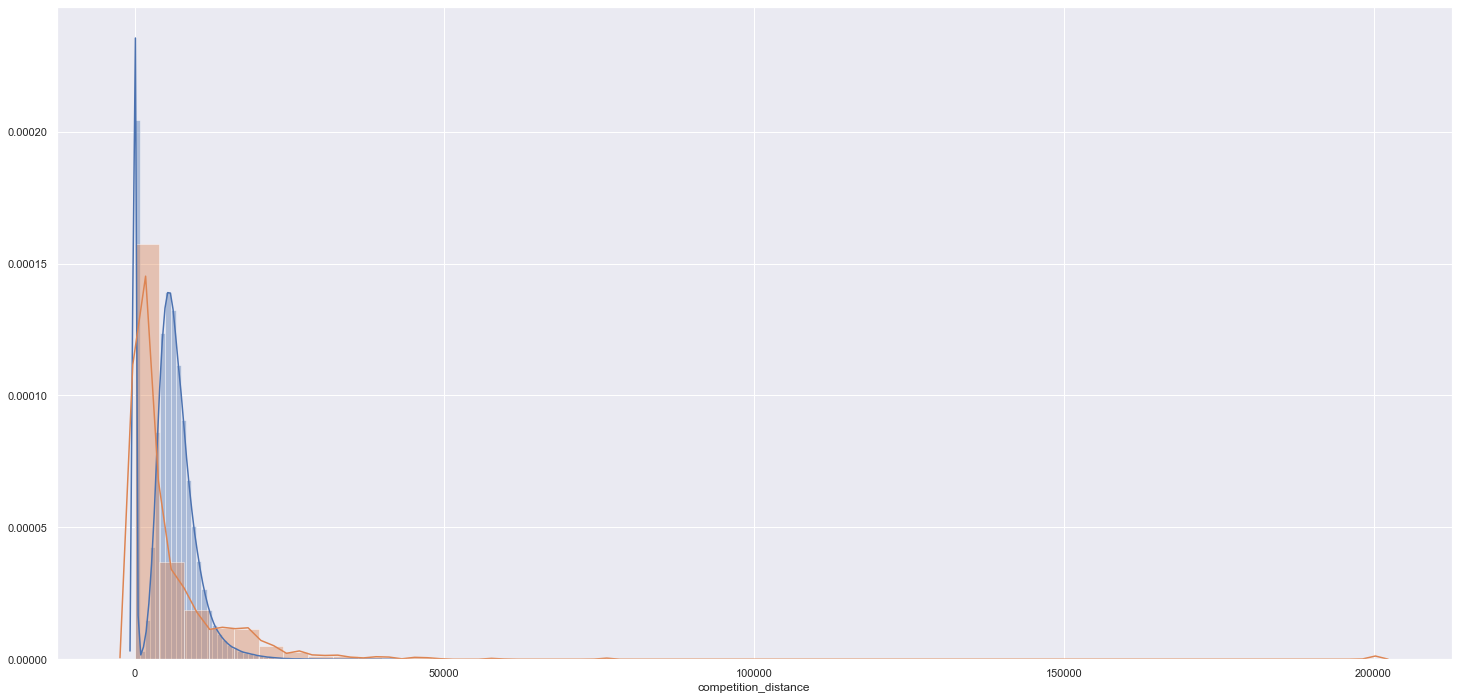

In [13]:
#central tendency - mean, median 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
        
#dispersion - std, min, max, range, skew, kurtosis     
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T        
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T        
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T        
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

#plotando a coluna sales 
sns.distplot(df1['sales']);
sns.distplot(df1['competition_distance']);

### **1.7.2 Atributos categoricos**

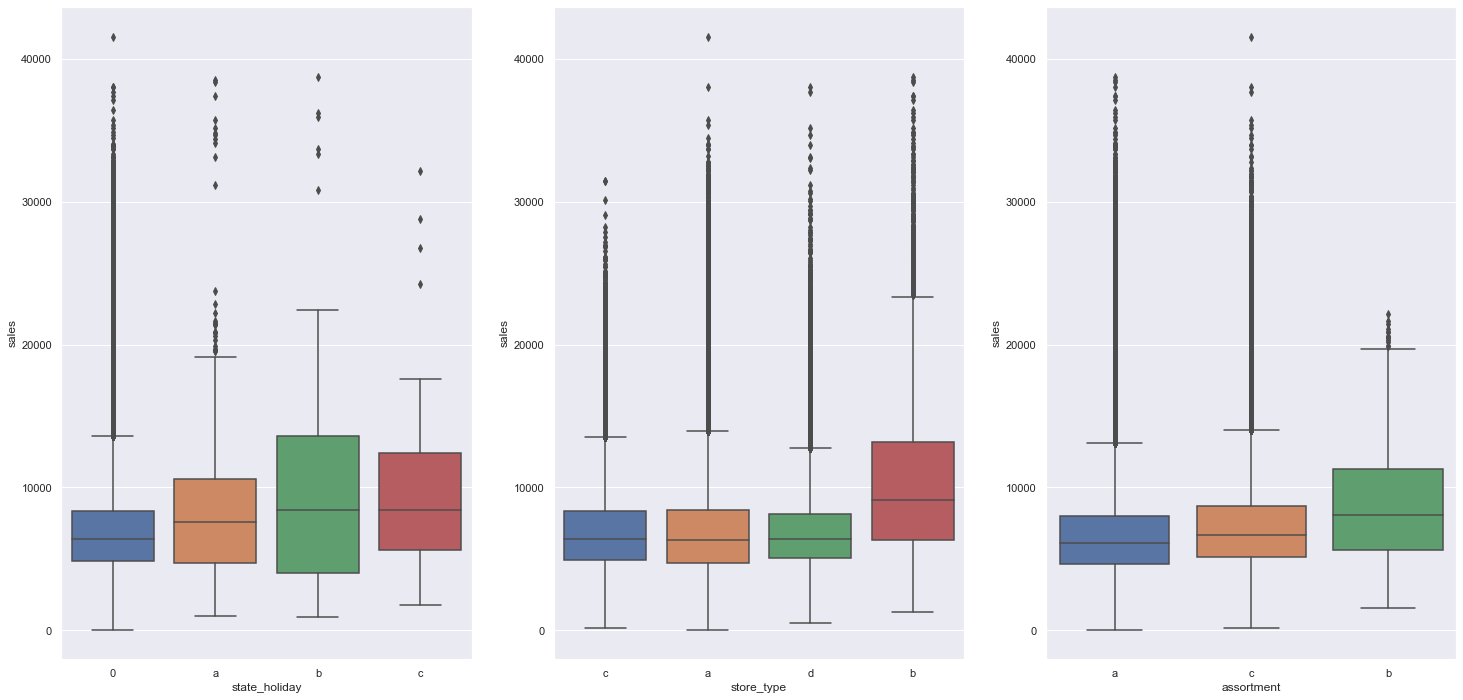

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

#criando variavel com valores diferentes de 0 
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

#fazendo a plotagem para detecção de outliers 
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1 );

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1 );

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1 );

# **2.0. ENGENHARIA DE ATRIBUTOS**

In [ ]:
#criando uma cópia do data frame, para ter um backup
df2 = df1.copy()

## **2.1. Mapa Mental de Hipoteses**

In [5]:
# Mapa mental de hipóteses 

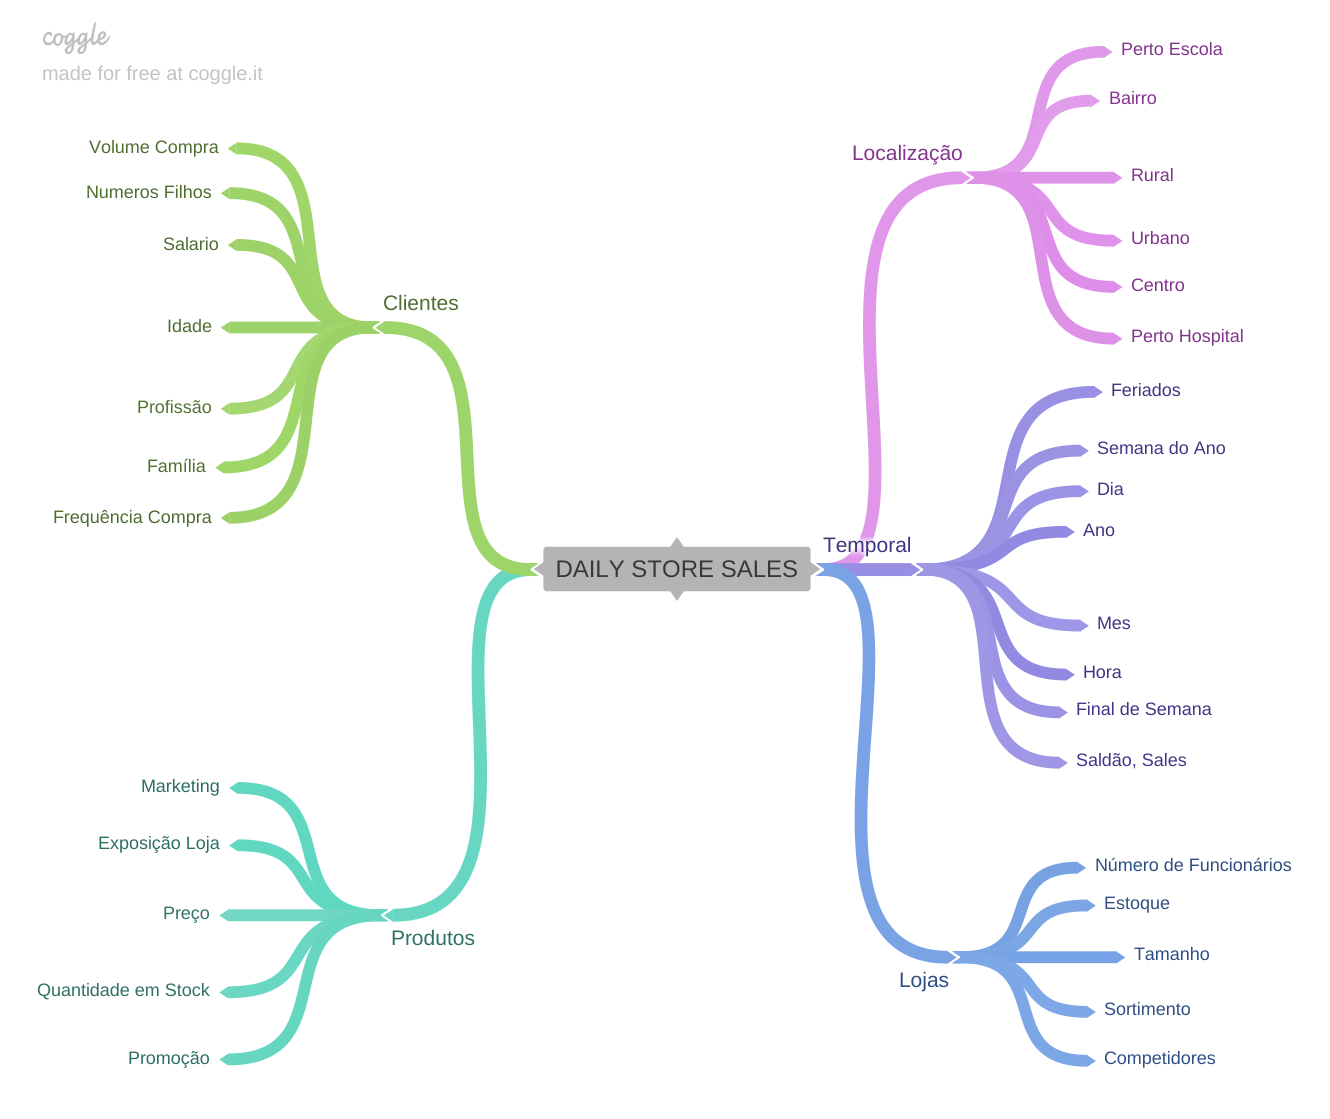

In [4]:
Image('/Users/andre.vitorino/Documents/repos/Predict-Time-Series-Test/MindMapHypothesis.png')

## 2.2. Criação de Hipoteses 

### **2.2.1 Hipoteses Loja**

**1**. Lojas com número maior de funcionários deveriam vender mais. 

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais. 

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.  

**6.** Lojas com competidores há mais tempo deveriam vender mais. 

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais. 

**2.** Lojas com maior exposição de produto deveriam vender mais. 

**3.** Lojas com produtos com preço menor deveriam vender mais. 

**4.** Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais. 

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais. 

**6.** Lojas com mais dias de promoção deveriam vender mais. 

**7.** Lojas com promoções consecutivas deveriam vender mais. 

### **2.2.3 Hipoteses Tempo**

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais. 

**2.** Lojas com maior exposição de produto deveriam vender mais. 

**3.** Lojas deveriam vender mais no segundo semestre do ano. 

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês. 

**5.** Lojas deveriam vender menos aos finais de semana. 

**6.** Lojas deveriam vender menos durante os feriados escolares. 

## **2.3. Lista Final de Hipoteses**

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas com maior exposição de produto deveriam vender mais.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## **2.4. Engenharia de Atributos**

In [ ]:
#fazendo a criação de novas variáveis 

#year 
df2['year'] = df2['date'].dt.year

#month 
df2['month'] = df2['date'].dt.month

#day 
df2['day'] = df2['date'].dt.day

#week of year 
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week 
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] ) /30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

'''mesma forma de fazer o código acima, com a diferença que com 7M(ou mais) de linhas no DF a linha de cima desempenha melhor: 

for n in range(len(df2)):
    if df2['assortment'][n] == 'a':
        df2['assortment'][n] = 'basic'
        
    if df2['assortment'][n] == 'b':
        df2['assortment'][n] = 'extra'
        
    else:
        df2['assortment'][n] = 'extended   '''
        

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

'''mesma forma de fazer o código acima, com a diferença que com 7M(ou mais) de linhas no DF a linha de cima desempenha melhor:

for n in range(len(df2)):
    if df2['assortment'][n] == 'a':
        df2['assortment'][n] = 'public_holiday'

    if df2['assortment'][n] == 'b':
        df2['assortment'][n] = 'easter_holiday'

    if df2['assortment'][n] == 'c':
        df2['assortment'][n] = 'christmas'

    else:
        df2['assortment'][n] = 'regular_day   '''

#  **3.0. FILTAGREM DE VARIAVEIS**

In [16]:
#criando uma cópia do data frame, para ter um backup
df3 = df2.copy()

## **3.1. Filtragem de linha**

In [ ]:
#FILTRAGEM DE LINHAS 
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. **Seleção das Colunas**

In [ ]:
# Selecionando colunas para excluir
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

cols_drop = df3.drop(cols_drop, axis=1)

In [ ]:
df3.columns

# **4.0 ANALISE EXPLORATÓRIA DE DADOS**

In [ ]:
df4 = df3.copy()

## **4.1. Analise Univariada**

### **4.1.1. Variavel Resposta**

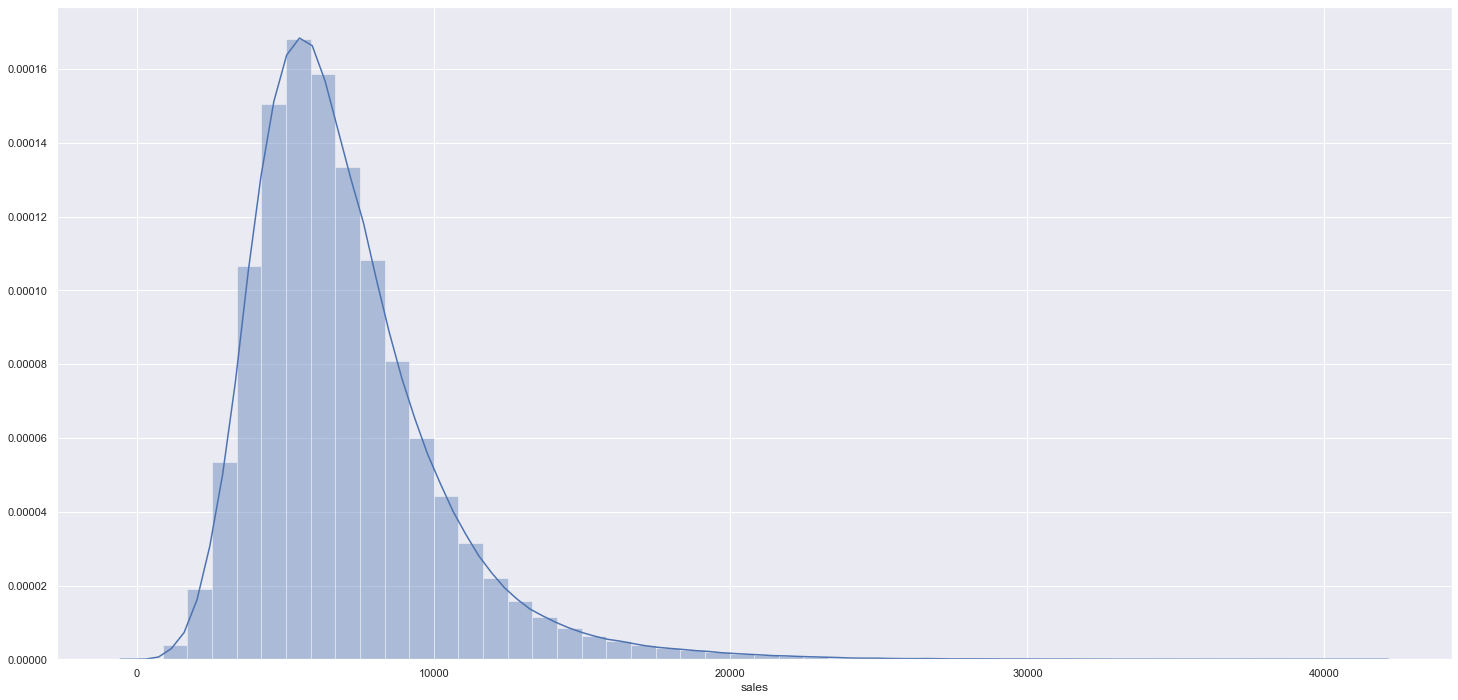

In [18]:
#Plotando a distribuição dos dados das vendas 
sns.distplot(df4['sales']);

#para gerar apenas o histograma 
#sns.distplot(df4['sales'], kde=False)

#método para aplicar o skew para o lado direito 
#sns.distplot(np.log1p((df4['sales'])))

### **4.1.2. VARIÁVEIS NUMÉRICAS**

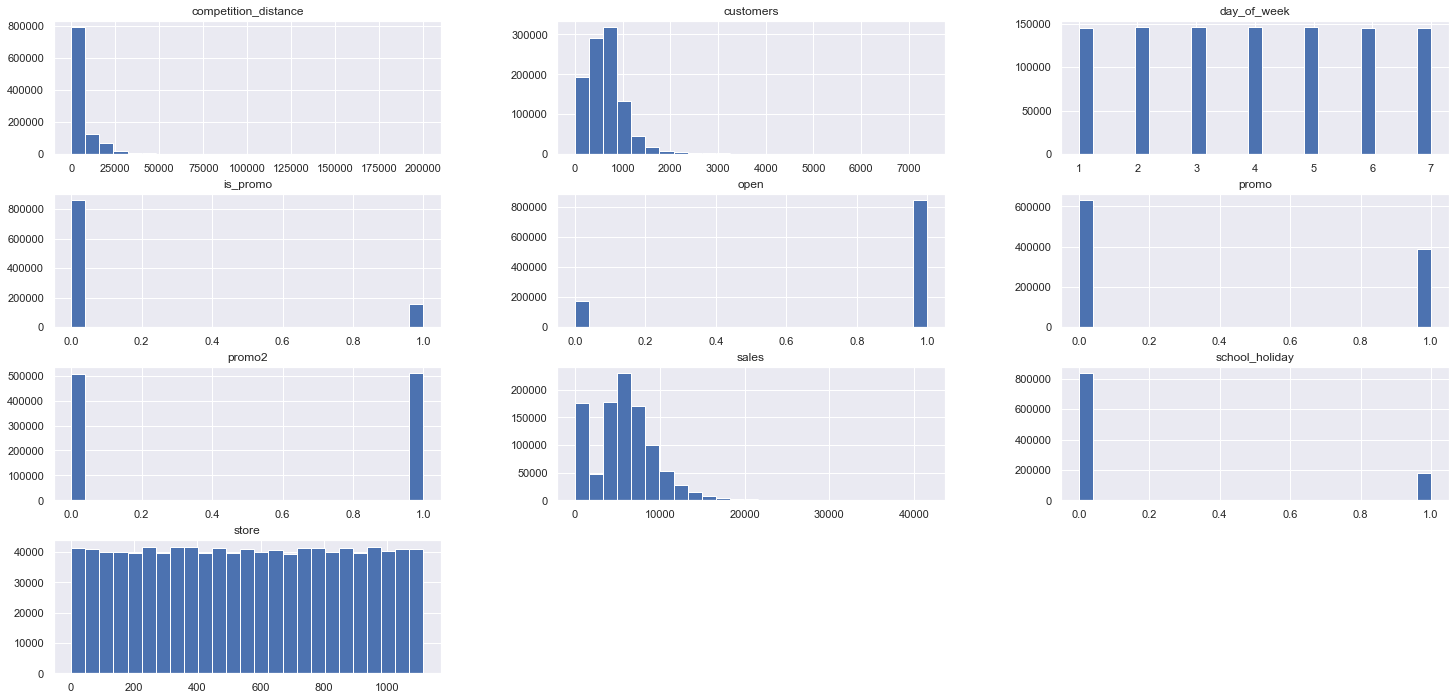

In [19]:
#plotando todos os gráficas da variável numérica 
num_attributes.hist(bins=25);

### **4.1.3. Variaveis Categoricas**

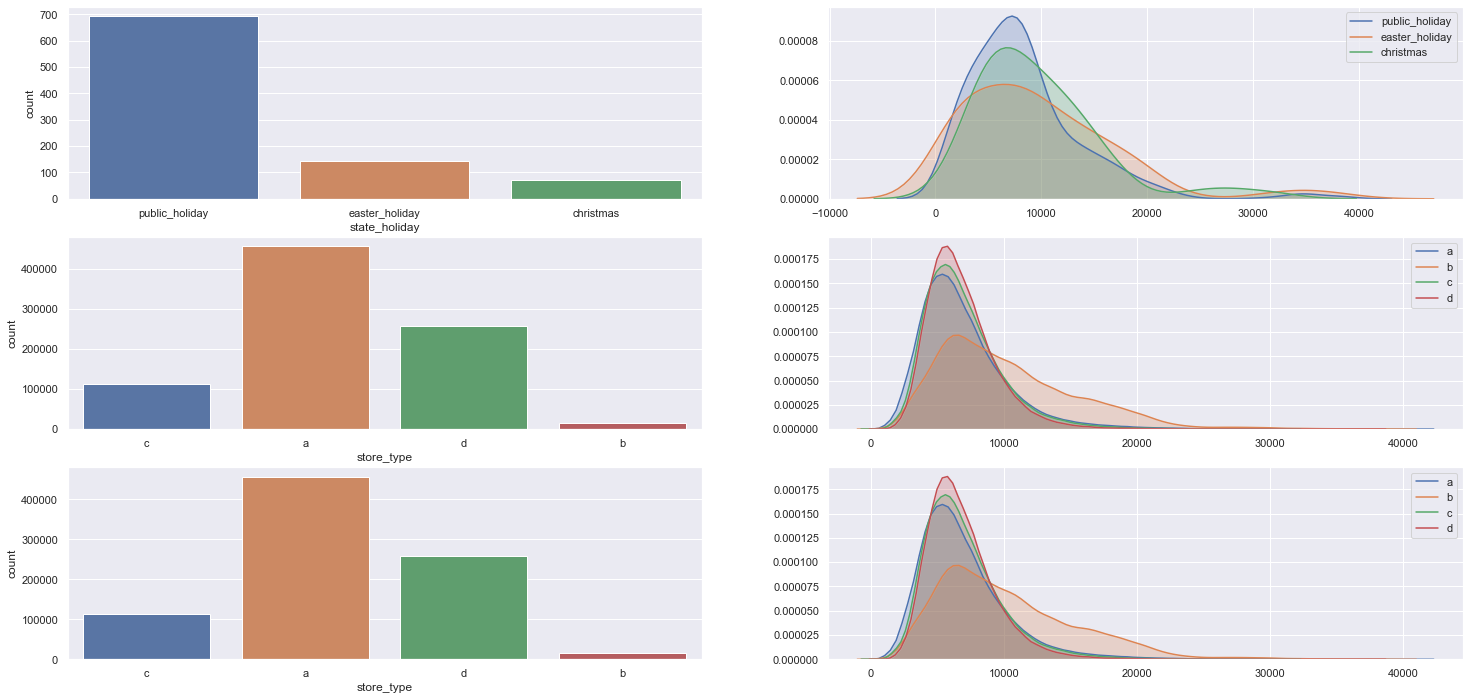

In [20]:
#Analisando os 5 primeiros atributos categóricos
cat_attributes.head()

#dropando as informações duplicadas 
df4['state_holiday'].drop_duplicates()

#state holiday
#usando comando para plottar mais de um gráfico 
#3 linhas, 2 colunas, grafico 1
plt.subplot(3,2,1)

#filtrando state_holiday para tirar os dias normais 
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

#3 linhas, 2 colunas, grafico 2
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday', shade='True');
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday', shade='True');
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas', shade='True');


#store_type
#3 linhas, 2 colunas, grafico 3
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

#3 linhas, 2 colunas, grafico 4
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a', shade='True');
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b', shade='True');
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c', shade='True');
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d', shade='True');

#assortment
#3 linhas, 2 colunas, grafico 5
plt.subplot(3,2,5)
sns.countplot(df4['store_type']);

#3 linhas, 2 colunas, grafico 6
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a', shade='True');
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b', shade='True');
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c', shade='True');
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d', shade='True');


## **4.2 ANALISE BIVARIADA**

### **H1.** Lojas com maior sortimento deveriam vender mais.
**Falsa:** Lojas com maior sortimento vendem menos

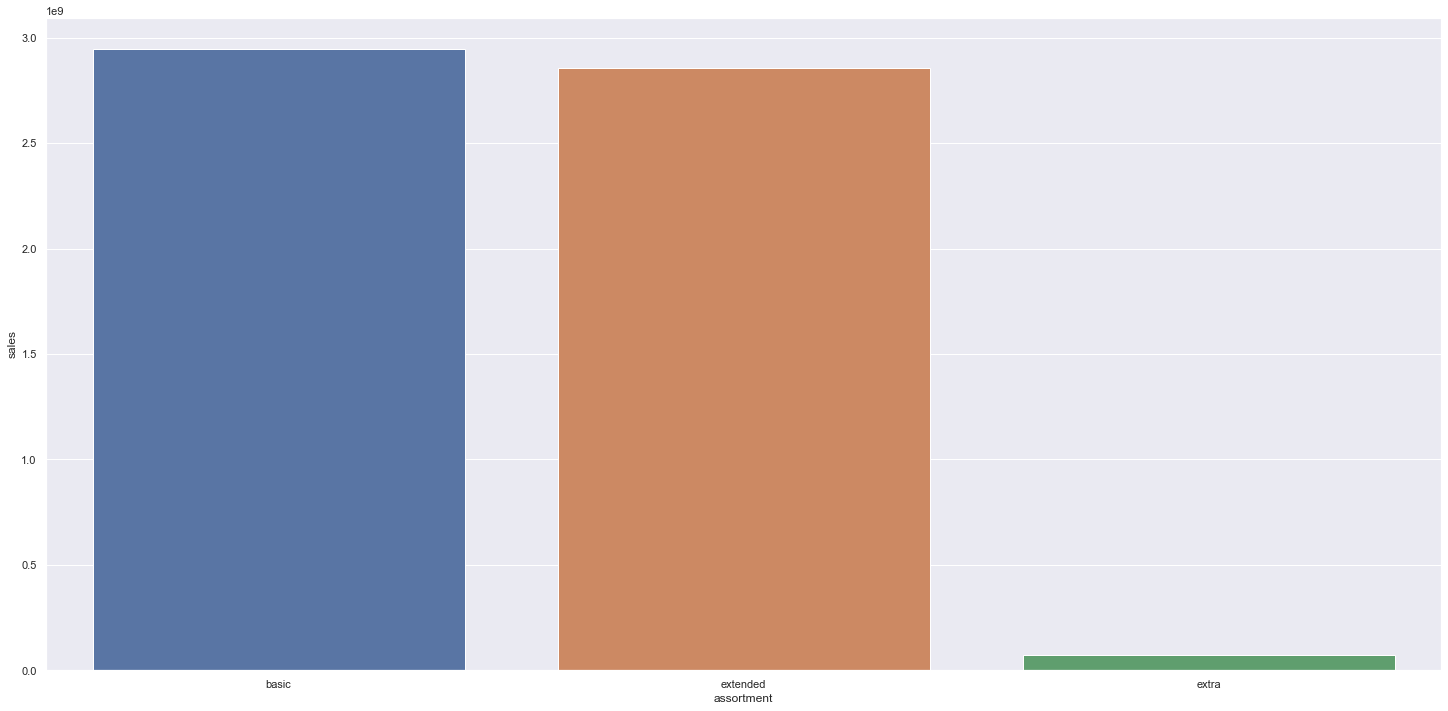

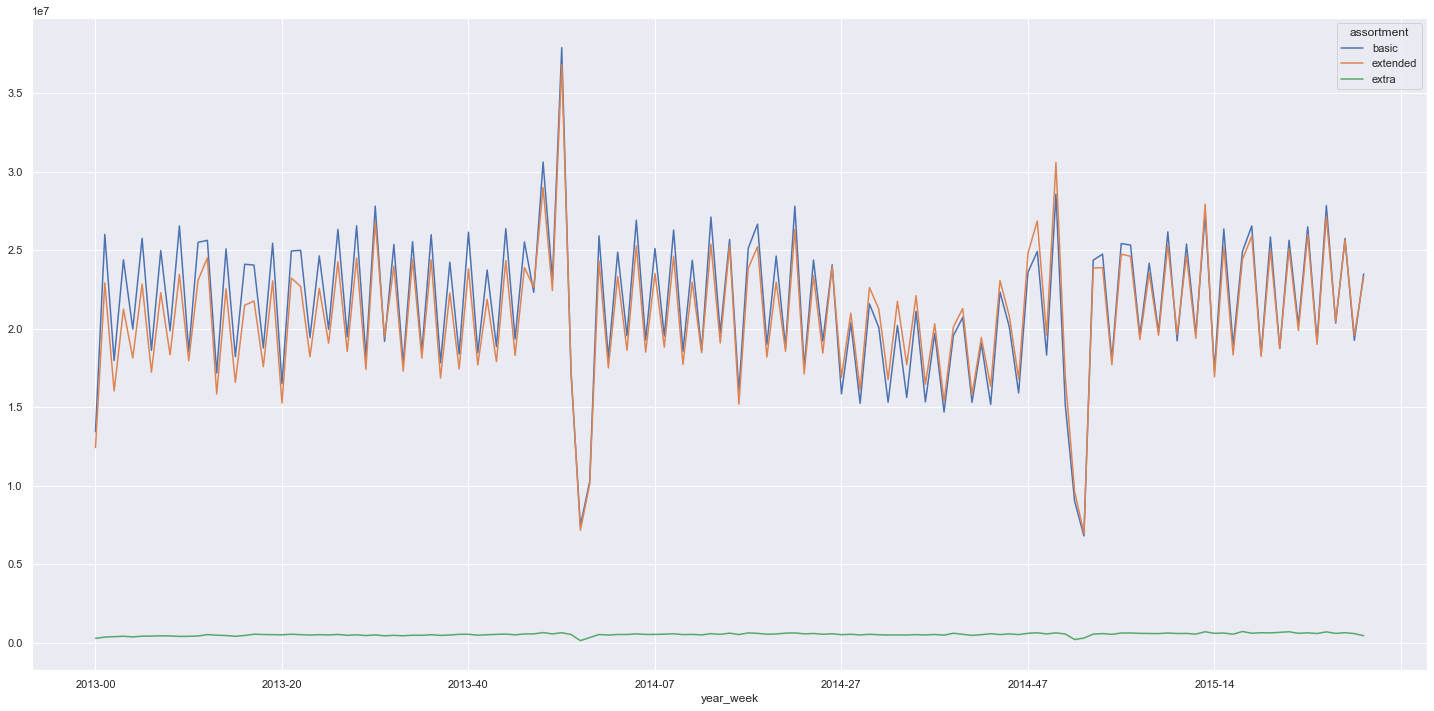

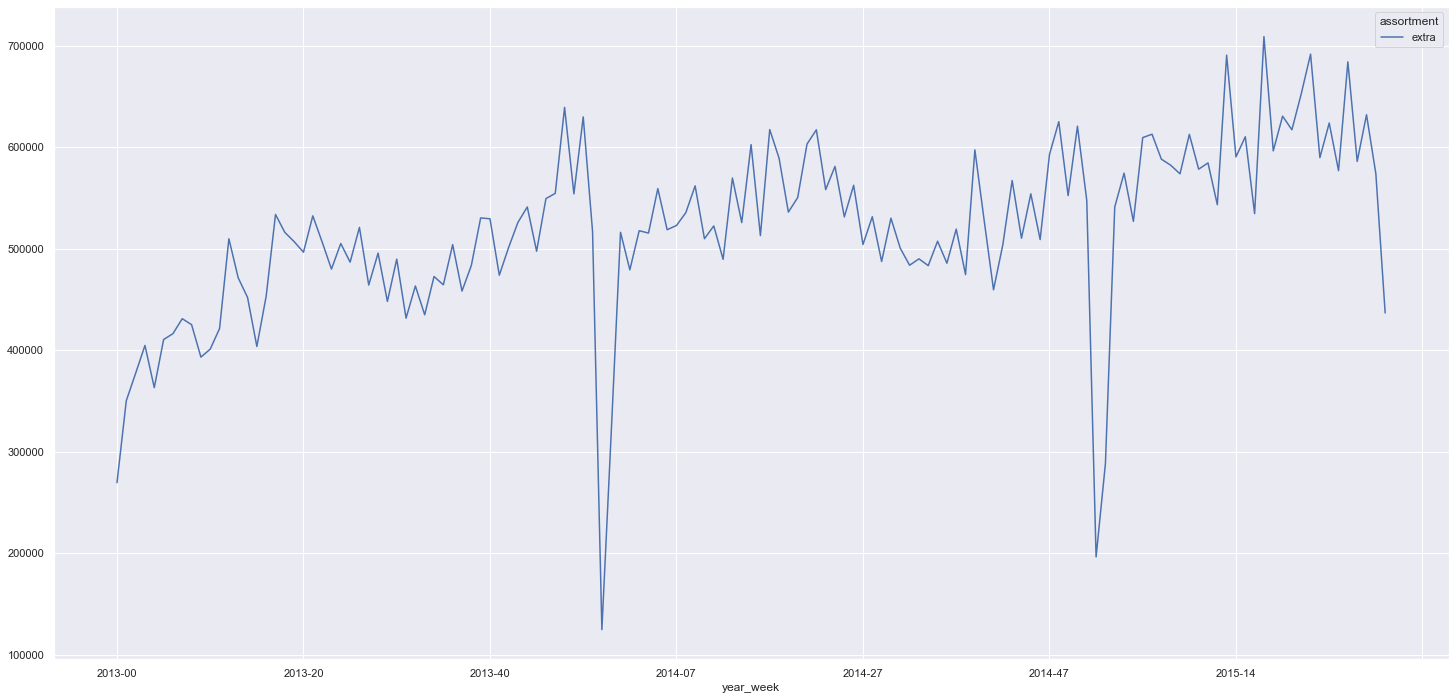

In [21]:
#agrupando todas as vendas por assortment 
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
#plotando o gráfico com as vendas por assortment 
sns.barplot(x='assortment', y='sales', data=aux1);

#agrupando todas as vendas por assortment e semanas do ano 
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
#fazendo a plotagem do gráfico com as vendas por assortment pelas semanas do ano 
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

#filtrando as vendas somente pelo assortment extra
aux3 = aux2[aux2['assortment'] == 'extra']
#criando um pivot para inverter as informações
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos vendem menos.
**Falso** Lojas com competidores mais próximos vendem mais 

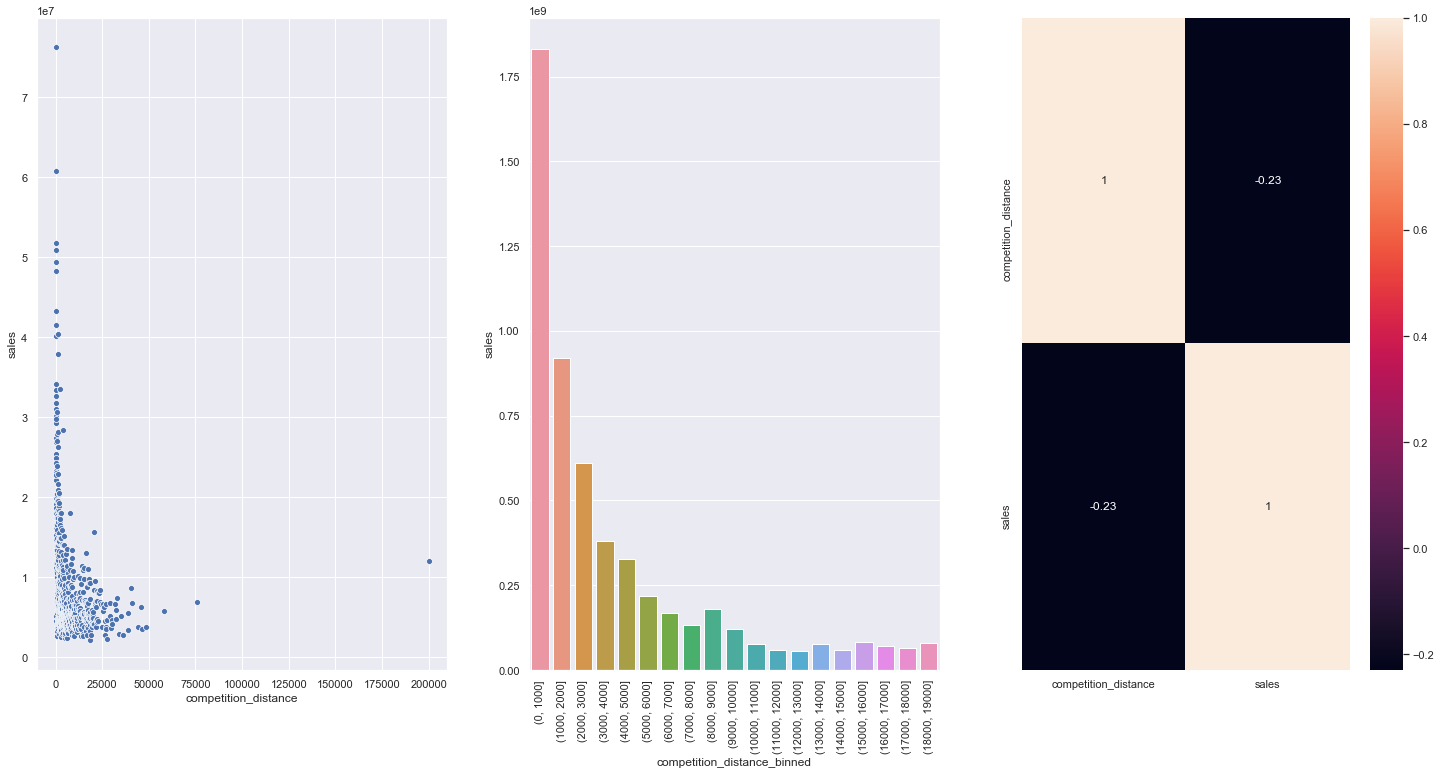

In [22]:
#agrupando todas as vendas pela distancia dos outros competidores até a nossa loja 
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#criando um conjunto de gráficos, com 1 linha e e 3 colunas 
#gráfico na posição 1 
plt.subplot(1,3,1)
#plotagem usando os pontos para visualizar melhor o comportamento dos dados
#o ';' no final da linha serve para evitar as mensagens de plottagem  
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

#gráfico na posição 2 
plt.subplot(1,3,2)
#criando grupos de 1k em 1k até 20k para agrupar as lojas de 1000 em mil metros em um único grupo 
bins = list(np.arange(0, 20000, 1000))
#aplicando os grupos de 1k em 1k na variavel 'competition_distance_binned'
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#agrupando as vendas pela distancia da loja 
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#fazendo a plotagem do gráfico com os grupos de 1k em 1k 
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
#rodando as legendas do eixo 'x' para melhor visualização 
plt.xticks(rotation = 90);

#gráfico na posição 3
plt.subplot(1,3,3)
#criando um heatmap para verificar a correlação entre a distancia e a quantidade de vendas 
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores a mais tempo vendem mais 
**Falsa:** Lojas com competidores a mais tempo vendem menos

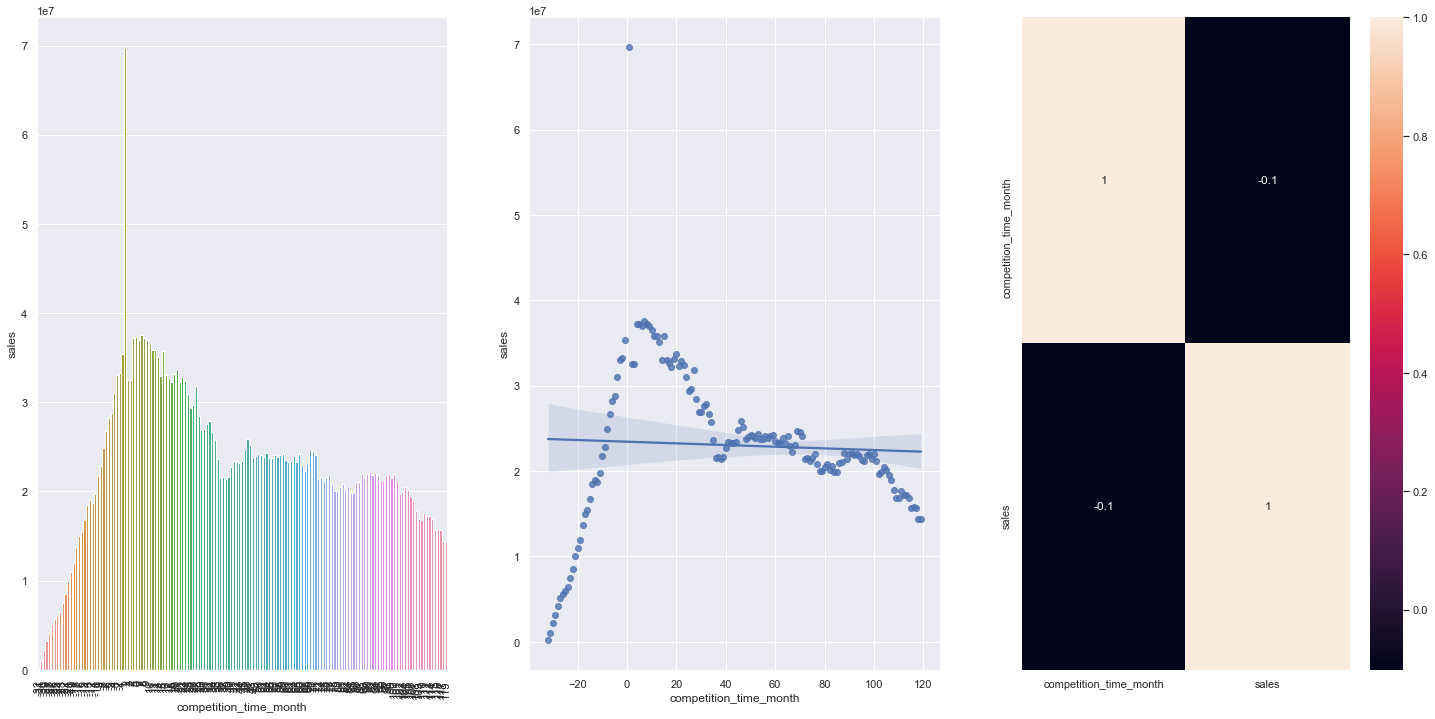

In [23]:
#criando lista com 1 linha 3 3 colunas 
#plot na posição 1 
plt.subplot(1,3,1)

#verificando a quantidade de vendas por meses 
#criando filtro de vendas por meses desde a abertura das lojas proximas 
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
#fazendo filtro com lojas com menos de 120 meses desde a abertura de outras lojas 
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
#fazendo a plotagem com a variavel filtrada 
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

#plot na posição 2
plt.subplot(1,3,2)

#fazendo a plotagem da tendência dos dados
sns.regplot(x='competition_time_month', y='sales', data=aux2);

#posição 3 
plt.subplot(1,3,3)
#gerando heatmap
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa:** Lojas com promoções a mais tempo vendem menos, depois de um certo período 

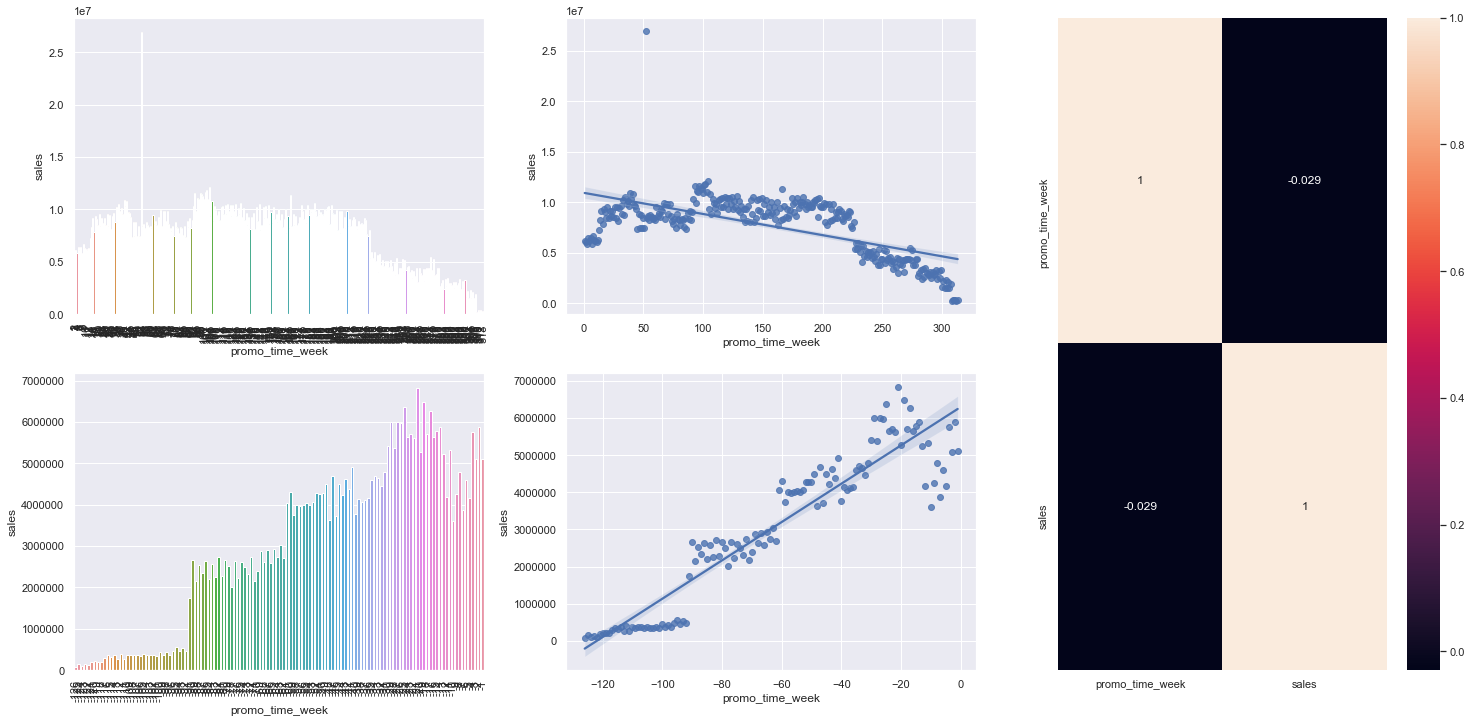

In [24]:
#gerando variavel para comparação das colunas 
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#criando um 'subplot' unindo as duas linhas da última coluna para ser usado como um gráfico só 
grid = GridSpec(2, 3)

#linha 0 coluna 0
plt.subplot(grid[0,0])

#filtrando a promoção como 'promoção extendida'
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção extendida
#plotando o gráfico de promoções extendidas 
sns.barplot(x='promo_time_week', y='sales', data=aux2);
#girando as legendas em 90 graus 
plt.xticks(rotation=90);

#coluna 0 linha 1 
plt.subplot(grid[0,1])
#plotando o gráfico da têndencia de vendas do primeiro gráfico 
sns.regplot(x='promo_time_week', y='sales',data=aux2);

#coluna 1 linha 0 
plt.subplot(grid[1,0])

#filtrando a promoção por 'promoção normal '
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção normal

#plotandoo o gráfico de vendas durante a promoção normal 
sns.barplot(x='promo_time_week', y='sales', data=aux3);
#girando as legendas em 90 graus
plt.xticks(rotation=90);

#coluna 1 linha 1 
plt.subplot(grid[1,1])
#plotando o gráfico da têndencia de vendas do segundo gráfico 
sns.regplot(x='promo_time_week', y='sales', data=aux3);

#todas as linhas da última coluna
plt.subplot(grid[:,2])
#plotando o heatmap da variavel 'aux1' para ver a correlação entre as variaveis 
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais</s>

### **H6.** Lojas com promoções consecutivas vendem mais 
**Falsa:** Lojas com promoções consecutivas vendem menos 

In [25]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


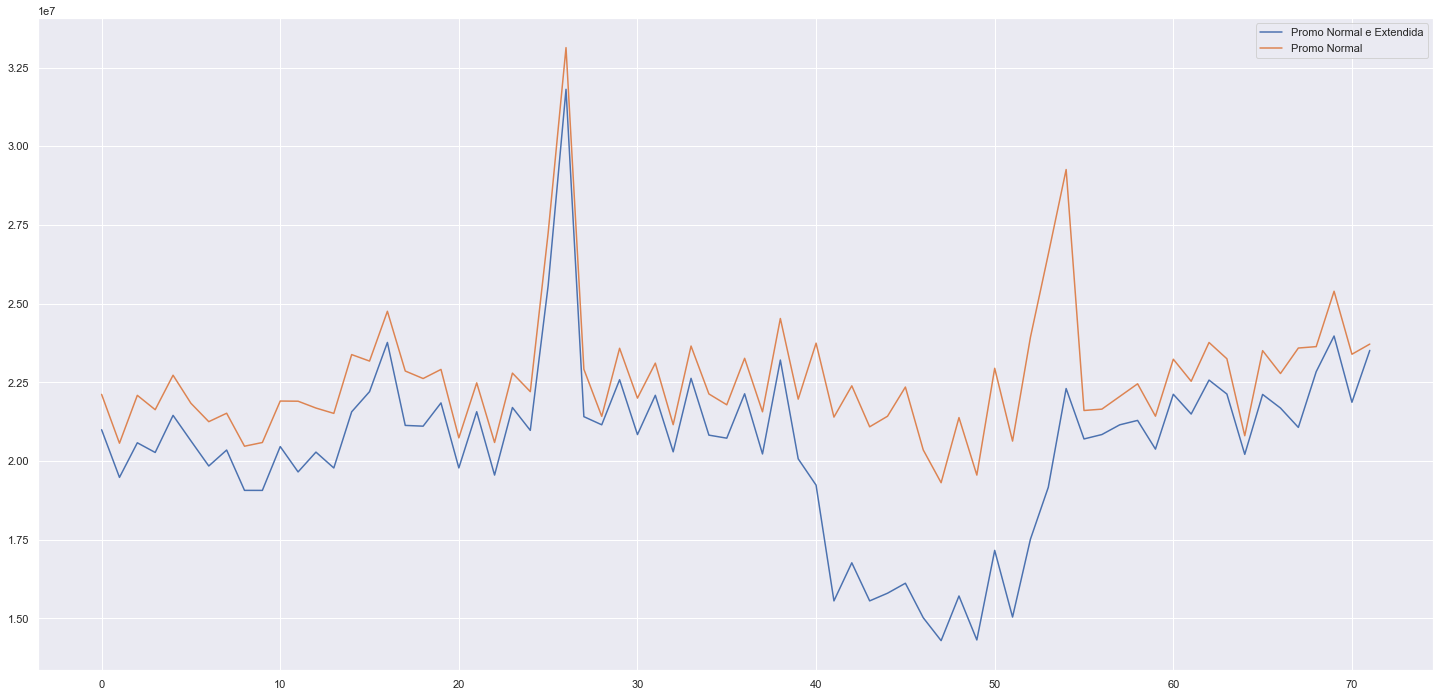

In [26]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);
plt.legend(['Promo Normal e Extendida', 'Promo Normal']);

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais. 
**Falsa:** Lojas abertas durante o feriado de natal não vendem mais 

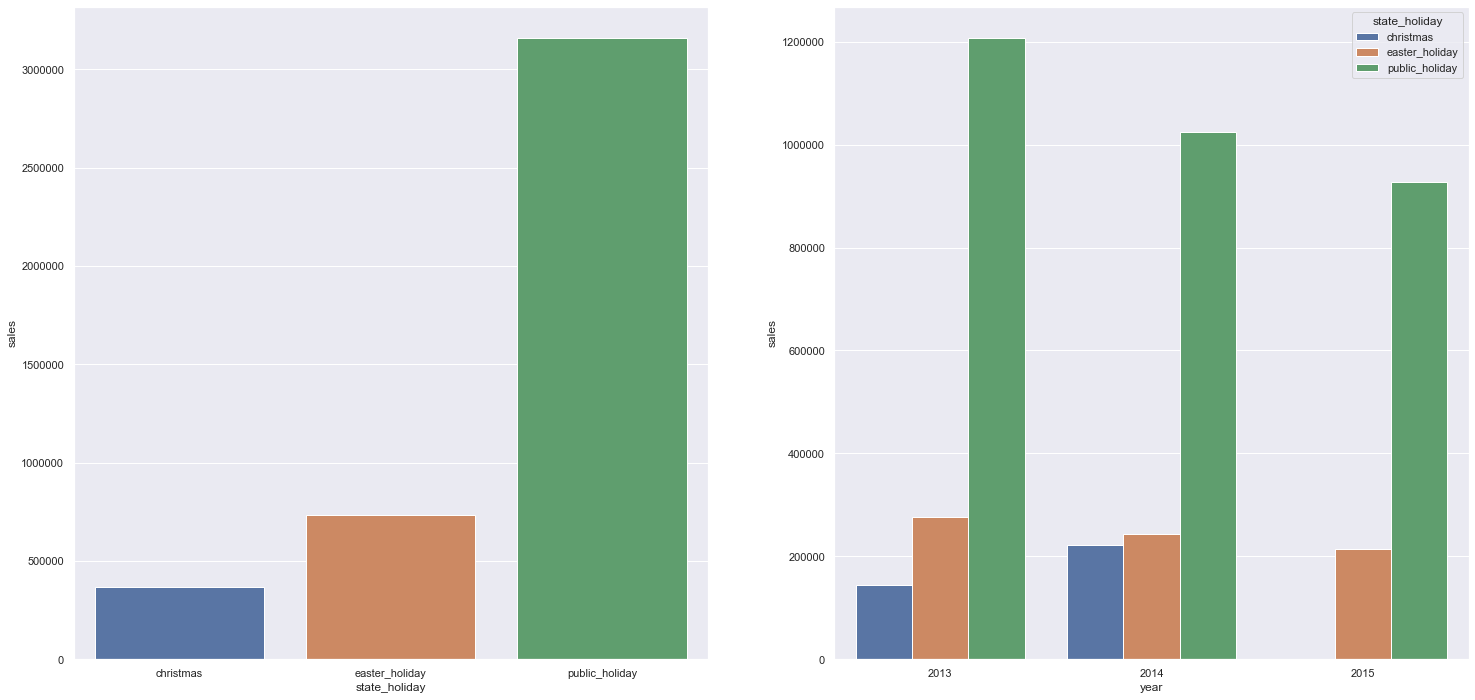

In [27]:
#criando filtro para tirar os dias regulares 
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['sales'])]

#linha 1 coluna 1  
plt.subplot(1,2,1)

#agrupando as vendas pelos feriados
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
#plotando gráfico de vendas por feriados 
sns.barplot(x='state_holiday', y='sales', data=aux1);

#linha 1 coluna 2
plt.subplot(1,2,2)

#agrupando as vendas por feriados através dos anos 
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
#plotando gráfico de vendas por feriados através dos anos 
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos 
**Falsa:** Lojas vendem menos ao longo dos anos 

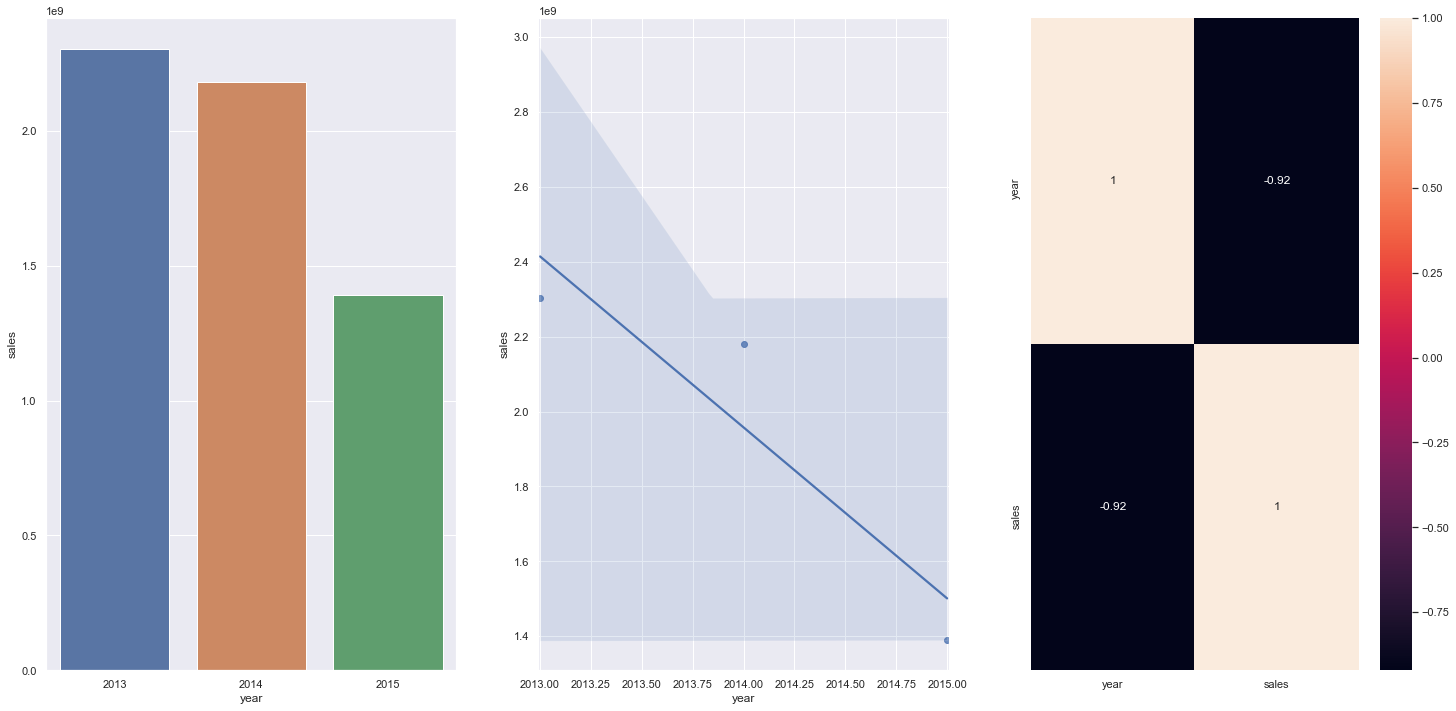

In [28]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano
**Falsa:** As lojas vendem menos no segundo semestre do ano 

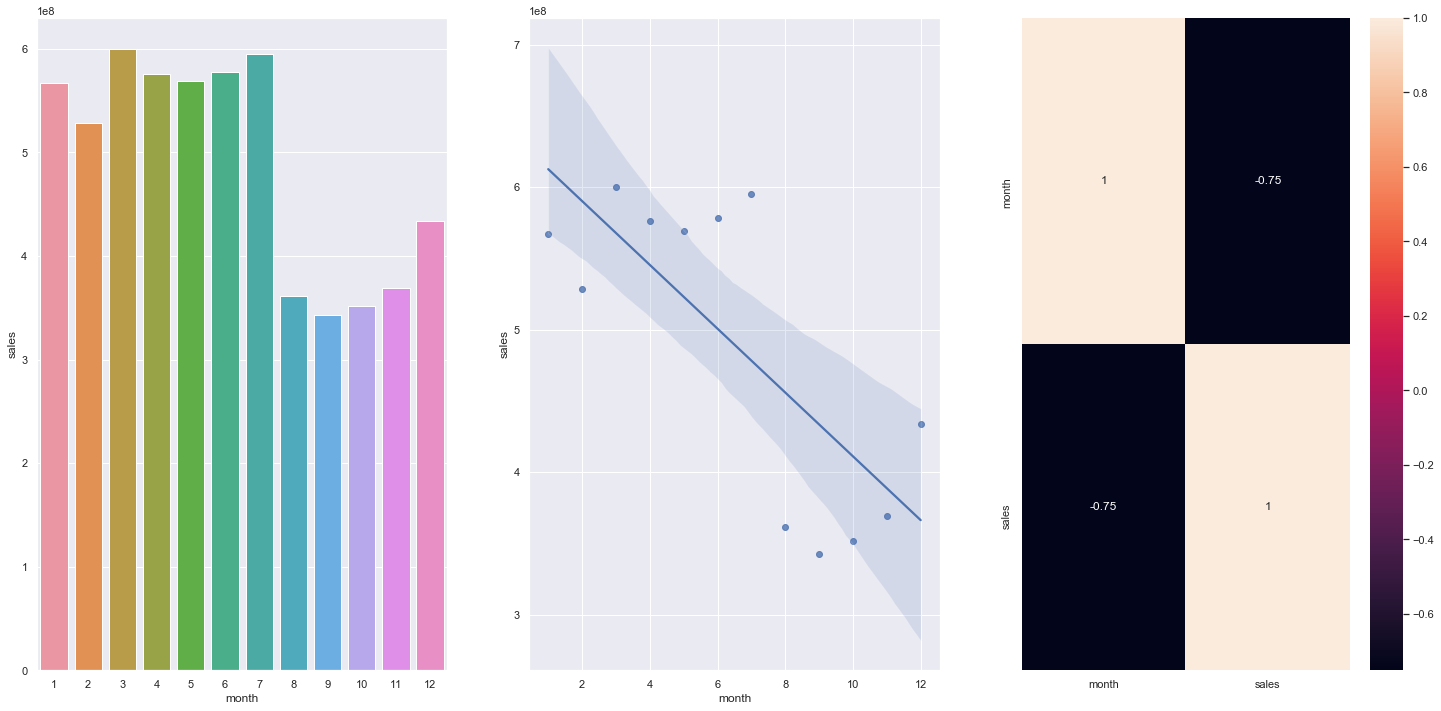

In [29]:
#criando variavel com as vendas por mês 
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

#linha 1, coluna 1, posição 1
plt.subplot(1,3,1)
#plotando as vendas por meses 
sns.barplot(x='month', y='sales', data=aux1);

#linha 1, coluna 1, posição 2
plt.subplot(1,3,2)
#plotando a tendência das vendas por meses 
sns.regplot(x='month', y='sales', data=aux1);

#linha 1, coluna 1, posição 3
plt.subplot(1,3,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês 
**Verdadeira:** As lojas vendem mais depois do dia 10 de cada mês 

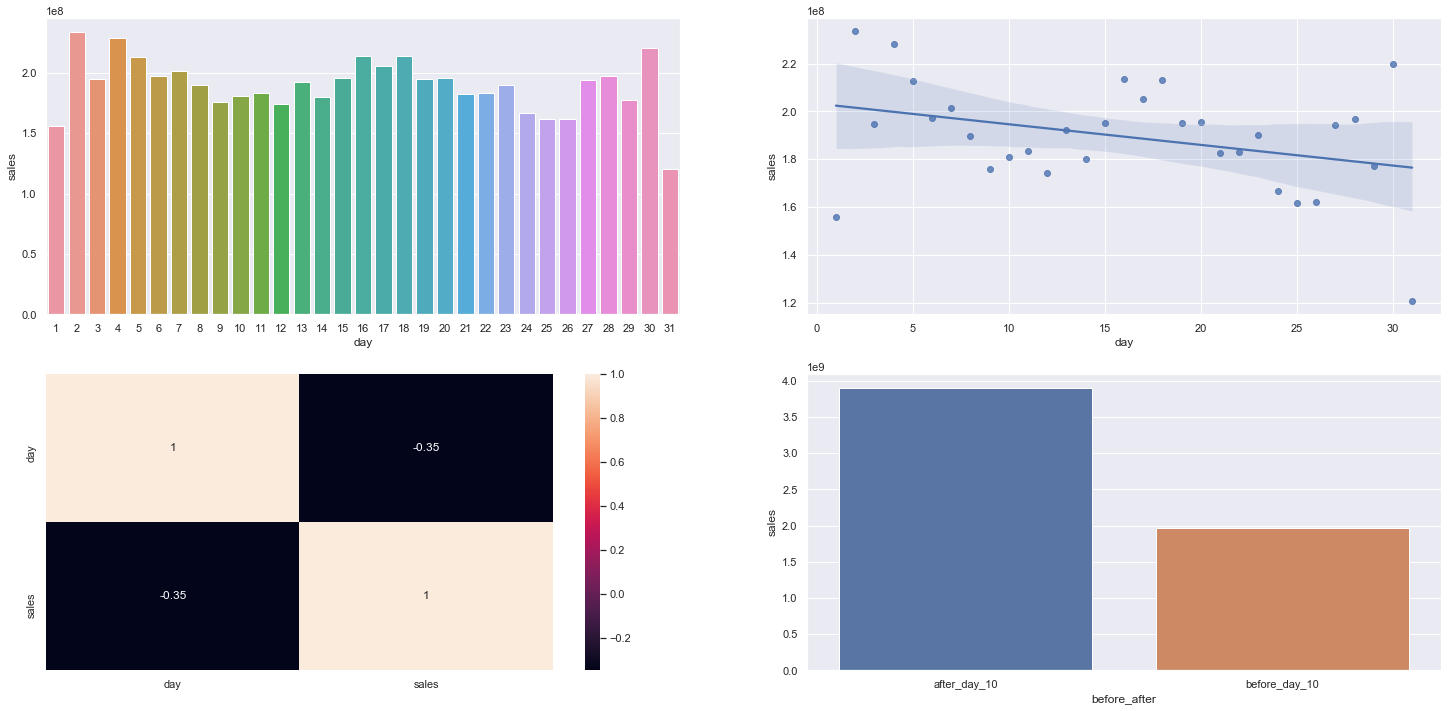

In [30]:
#criando variavel com as vendas por dias 
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

#linha 1, coluna 1
plt.subplot(2,2,1)
#plotando as vendas por dias 
sns.barplot(x='day', y='sales', data=aux1);

#linha 1, coluna 2
plt.subplot(2,2,2)
#plotando a tendência das vendas por dias 
sns.regplot(x='day', y='sales', data=aux1);

#linha 2, coluna 1
plt.subplot(2,2,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

#linha 2, coluna 2 
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos ao finais de semana 
**Verdadeiro:** Lojas vendem menos aos finais de semana 

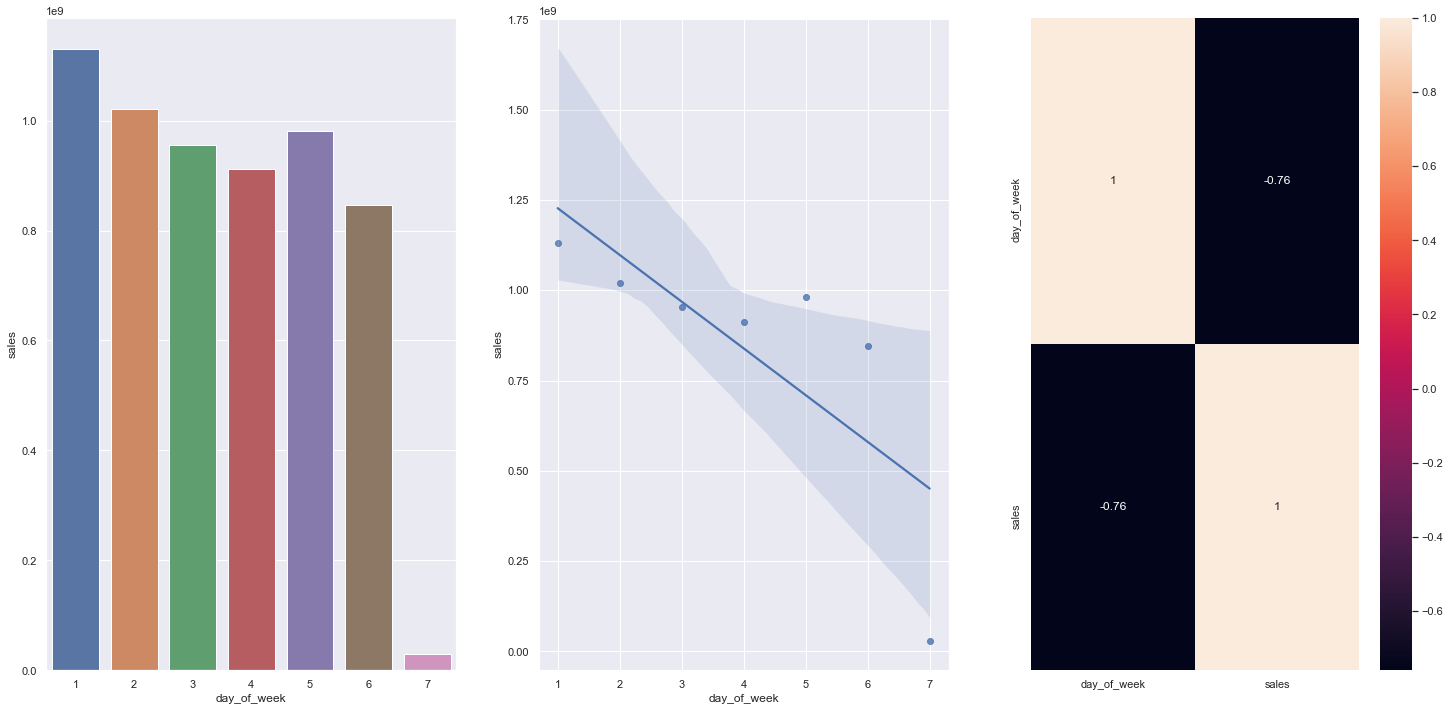

In [31]:
#criando variavel com as vendas por dias da semana  
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

#linha 1, coluna 1
plt.subplot(1,3,1)

#plotando as vendas por dias da semana 
sns.barplot(x='day_of_week', y='sales', data=aux1);

#linha 1, coluna 2
plt.subplot(1,3,2)

#plotando a tendência das vendas por dias da semana 
sns.regplot(x='day_of_week', y='sales', data=aux1);

#linha 1, coluna 3
plt.subplot(1,3,3)

#gerando a correlação entre as colunas da variavel 'aux1'
x_heat = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares
**Verdadeiro:** As lojas vendem menos durante os feriados escolares, com exceção do mês de agosto  

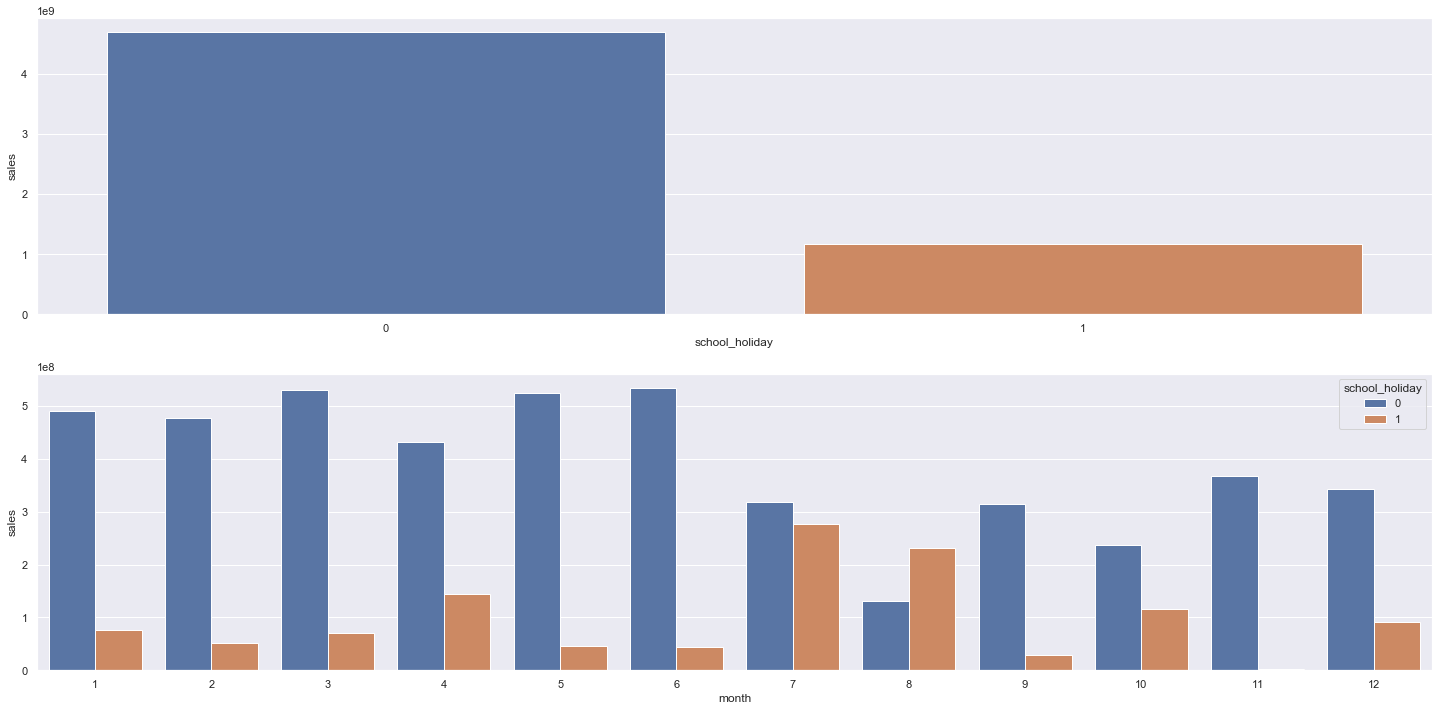

In [32]:
#criando variavel com as vendas por dias da semana  
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
#linha 1, coluna 1
plt.subplot(2,1,1)
#plotando as vendas por dias da semana 
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2);

## **4.3. ANALISE MULTIVARIADA**

## **ATRIBUTOS NUMERICOS**

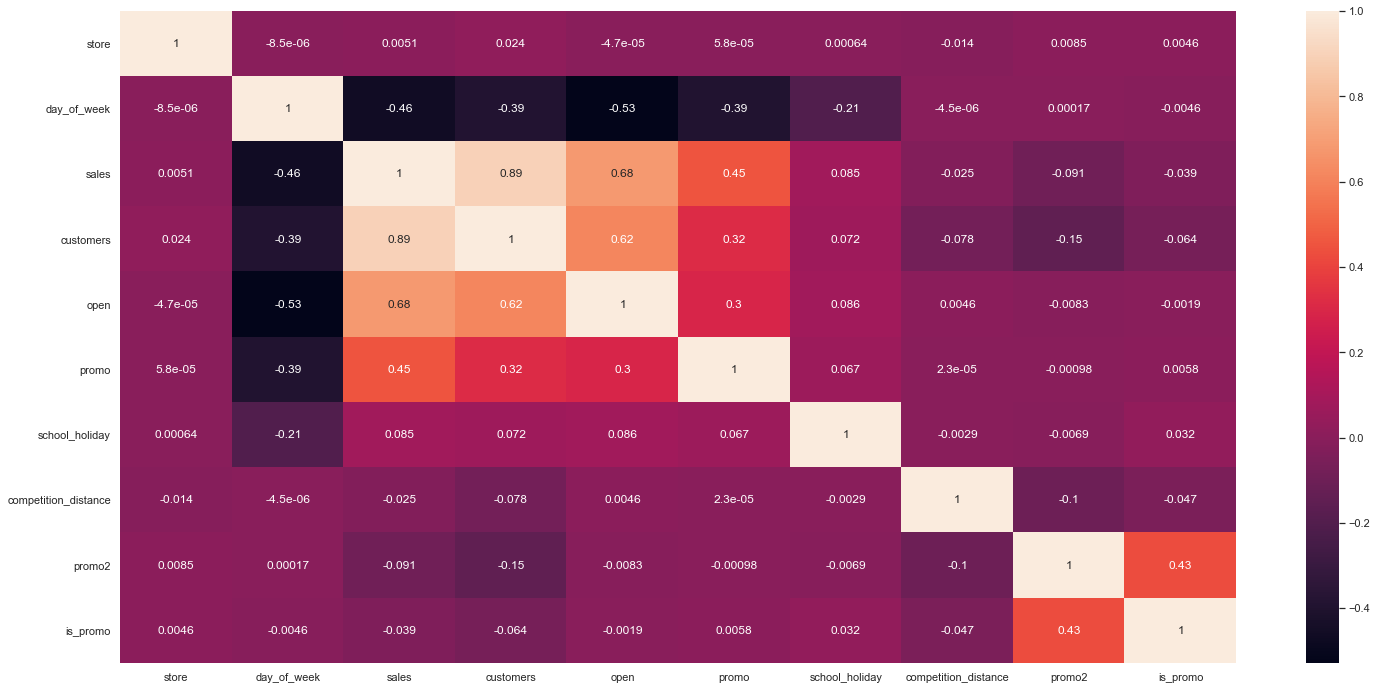

In [33]:
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True);

In [34]:
a = df4.select_dtypes(include='object')

In [35]:
a1 = cramer_v(a['state_holiday'] ,a['state_holiday'] )
a2 = cramer_v(a['state_holiday'] ,a['store_type'] )
a3 = cramer_v(a['state_holiday'] ,a['assortment'] )

a4 = cramer_v(a['store_type'] ,a['state_holiday'] )
a5 = cramer_v(a['store_type'] ,a['store_type'] )
a6 = cramer_v(a['store_type'] ,a['assortment'] )

a7 = cramer_v(a['assortment'] ,a['state_holiday'] )
a8 = cramer_v(a['assortment'] ,a['store_type'] )
a9 = cramer_v(a['assortment'] ,a['assortment'] )

df = pd.DataFrame({'state_holiday':[a1, a2, a3],
                   'store_type':[a4, a5, a6],
                   'assortment':[a7, a8, a9]})
df = df.set_index(df.columns)

In [36]:
df

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


# **5.0 PREPARAÇÃO DOS DADOS**

In [37]:
df5 = df4.copy()

## **5.1 Normalização**

In [38]:
#nenhum dado precisou ser normalizado nesse DF 

## **5.2 Reescalação**

In [39]:
#Separando as variáveis númericas das demais variáveis 
a = df5.select_dtypes(include=['int64', 'float64'])

In [40]:
a.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,555,1,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,625,1,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,821,1,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1498,1,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,559,1,1,1,29910.0,0,0,2015,7,31,31


In [41]:
#precisamos verificar qual variável tem outlier para decidir qual scaling será aplicado 
#RobustScaler é aplicado quando há outlier na variável 
#MinMaxScaler é aplicado quando n]ao há outlier na variável 

from sklearn.preprocessing import RobustScaler, MinMaxScaler

robust = RobustScaler()
mms = MinMaxScaler()

#VARIÁVEIS NÃO CÍCLICAS 

#competition_distance 
df5['competition_distance'] = robust.fit_transform(df5[['competition_distance']].values)

#competition_time_month 
df5['competition_time_month'] = robust.fit_transform(df5[['competition_time_month']].values)

#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## **5.3 Transformação**

### **5.3.1 Encoding**

In [42]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [43]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
#state_holiday - One Hot Encoder(Dumming Encoding)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoder
df5['store_type'] = LE.fit_transform(df5['store_type'])

#assortment - 
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### **5.3.2 Transformação da variável resposta**

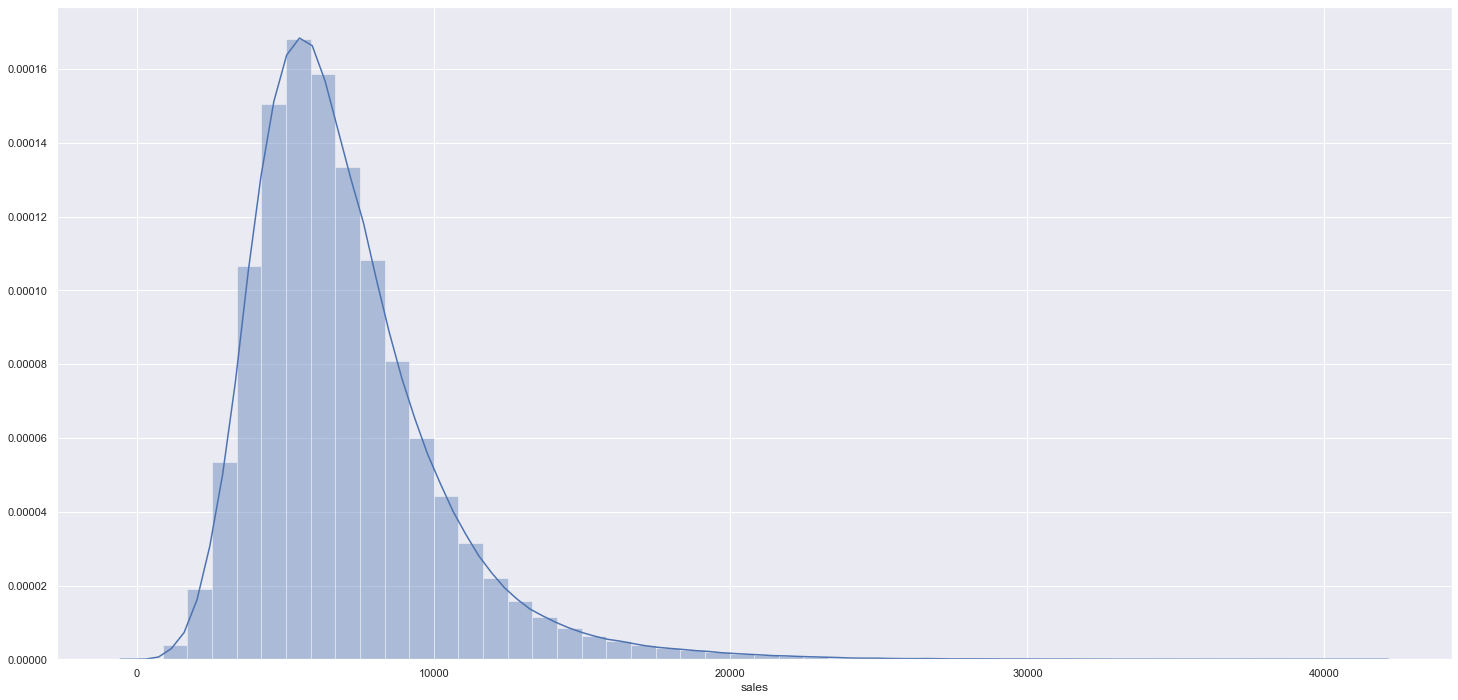

In [44]:
#plotando a distribuição dos dados
sns.distplot(df5['sales']);

In [45]:
#reescalando a variável resposta 
df5['sales'] = np.log1p(df5['sales'])

In [46]:
#VARIÁVEIS CÍCLICAS 

#aplicando o seno e cosseno nas variáveis cíclicas, para fazer a transformação dos dados de categóricos(letras) para inteiros 

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi /30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi /30)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi /12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi /12)))

#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi /7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi /7)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi /52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi /52)))

In [47]:
#verificando as alterações
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,555,1,1,1,2,1,-0.170968,9,2008,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,625,1,1,1,0,1,-0.283871,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,821,1,1,1,0,1,1.903226,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1498,1,1,1,2,3,-0.275806,9,2009,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,559,1,1,1,0,1,4.448387,4,2015,0,31,2015,0,Jul,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984


# **6.0 SELEÇÃO DE ATRIBUTOS**

In [48]:
df6 = df5.copy()

## **6.1 Dividir base de dados em treino e teste**

In [49]:
drop_cols = ['week_of_year', 'day_of_week', 'month', 'day', 'promo_interval', 'month_map', 'year_week', 'competition_since','promo_since', 'customers','open']
df6 = df6.drop(drop_cols, axis=1)

In [50]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(6*7)

Timestamp('2015-06-19 00:00:00')

In [51]:
#criando base de dados de treino 
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#criando base de dados de teste 
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training min date in train base: {}'.format(X_train['date'].min()))
print('Training max date in train base: {}'.format(X_train['date'].max()))

print('\nTraining min date in test base: {}'.format(X_test['date'].min()))
print('Training max date in test base: {}'.format(X_test['date'].max()))

Training min date in train base: 2013-01-01 00:00:00
Training max date in train base: 2015-06-18 00:00:00

Training min date in test base: 2015-06-19 00:00:00
Training max date in test base: 2015-07-31 00:00:00


## **6.2 Buruta como seletor de atributos**
**RESULTADOS DO BORUTA JÁ SALVOS EM VARIÁVEL**

In [52]:
'''ajustando as variáveis de treino e teste para que possam ser aplicadas no boruta 

x_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = Y_train.values.ravel()

#defirindo parametros do algoritmo random forest 
rf = RandomForestRegressor(n_jobs = -1)

#definindo parametros do boruta 
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0).fit(x_train_n, y_train_n)'''

"ajustando as variáveis de treino e teste para que possam ser aplicadas no boruta \n\nx_train_n = X_train.drop(['date', 'sales'], axis=1).values\ny_train_n = Y_train.values.ravel()\n\n#defirindo parametros do algoritmo random forest \nrf = RandomForestRegressor(n_jobs = -1)\n\n#definindo parametros do boruta \nboruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0).fit(x_train_n, y_train_n)"

### **6.2.1 Melhores atributos segundo Boruta**

In [53]:
'''criando uma lista com as colunas que foram selecionadas pelo boruta 
cols_selected = boruta.support_.tolist()

#criando variável para localizar as colunas que foram selecionadas 
# VERIFICAR SE ESSAS COLUNAS AINDA ESTÃO NO DF E TIRA-LAS CASO ESTEJAM 'customers', 'open'
x_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#verificando colunas não selecionadas 
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))'''

"criando uma lista com as colunas que foram selecionadas pelo boruta \ncols_selected = boruta.support_.tolist()\n\n#criando variável para localizar as colunas que foram selecionadas \n# VERIFICAR SE ESSAS COLUNAS AINDA ESTÃO NO DF E TIRA-LAS CASO ESTEJAM 'customers', 'open'\nx_train_fs = X_train.drop(['date', 'sales'], axis=1)\ncols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()\n\n#verificando colunas não selecionadas \ncols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))"

## **6.3 Seleção manual de atributos**
**RESULTADOS DO BORUTA SALVOS AQUI**

In [54]:
cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                        'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                        'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin',
                        'week_of_year_cos']

cols_not_selected_boruta = ['is_promo','open','school_holiday','state_holiday_christmas','state_holiday_easter_holiday',
                            'state_holiday_public_holiday','state_holiday_regular_day','year']

#colunas para adiciona 
feat_to_add = ['date', 'sales']

#atributos finais 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# **7.0 MODELAGEM DE MACHINE LEARNING**

In [55]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
x_training = X_train[cols_selected_boruta_full]

## **7.1 Média do Modelo**

In [56]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# predição 
#agrupando as vendas por loja e tirando a média dos valores e salvando em uma nova variável 
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
#juntando o aux2 no aux1 pea coluna 'store'
aux1 = pd.merge(aux1, aux2, how='left', on='store')
#criando coluna com os valores de predição que nada mais são do que os valores das vendas, para poder em seguida tirar as médias de vendas
yhat_baseline = aux1['predictions']

#performance 
#criando variável com o valor do erro para o algoritmo de 'média de modelo'
baseline_result = ml_error('Average Model', Y_test, yhat_baseline)
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## **7.2 Modelo de regressão linear**

In [57]:
#modelo 
lr = LinearRegression().fit(x_train, Y_train)

#predição 
yhat_lr = lr.predict(x_test)

#performance 
lr_error = ml_error('Linear Regression model', np.expm1(Y_test), np.expm1(yhat_lr))
lr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression model,1867.089774,0.292694,2671.049215


### 7.2.1 Modelo de regressão linear - Validação cruzada 

In [58]:
lr_result_cv = cross_validation(x_training, 5, 'Croos Validation', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Croos Validation,1959.98 +/- 11.45,0.31 +/- 0.0,2811.89 +/- 16.26


## **7.3 Modelo de regressão linear  regularizado - Lasso**

In [59]:
#modelo 
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

#predição 
yhat_lrr = lrr.predict(x_test)

#performance 
lrr_error = ml_error('Linear Regression regularized model - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression regularized model - Lasso,1891.704881,0.289106,2744.451737


### **7.3.1 Modelo de regressão linear Lasso - Validação cruzada**

In [60]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1982.28 +/- 12.74,0.31 +/- 0.0,2856.53 +/- 17.95


## **7.4 Random Forest Regressor**

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
#modelo 
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0).fit(x_train, Y_train)

#predição 
yhat_rf = rf.predict(x_test)

#performance 
rf_error = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_error

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.655769,0.10038,1014.211933


### **7.4.1 Random Forest Regressor - Validação Cruzada**

In [63]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,213.72 +/- 1.93,0.03 +/- 0.0,358.41 +/- 5.48


## **7.5 XGBoost Regressor** 

In [72]:
import xgboost as xgb

In [65]:
#modelo 
xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10, subsample=0.7, colsample_bytee=0.9).fit(x_train, Y_train)

#predição 
yhat_xgb = xgb.predict(x_test)

#performance 
xgb_error = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_error

[19:54:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.606385,0.949503,7330.742164


### **7.5.1 XGBoost Regressor - Validação Cruzada**

In [66]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgb, verbose=True)
xgb_result_cv


KFold Number: 5
[19:56:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[19:57:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[19:59:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This ma

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6592.3 +/- 32.41,0.95 +/- 0.0,7270.6 +/- 37.32


## **7.6 Comparando o resultado dos modelos**

### **7.6.1 Resultado Único**

In [67]:
modelling_result = pd.concat([baseline_result, lr_error, lrr_error, rf_error, xgb_error])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.655769,0.100380,1014.211933
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression model,1867.089774,0.292694,2671.049215
0,Linear Regression regularized model - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.606385,0.949503,7330.742164


### **7.6.1 Resultado Real - Validação Cruzada**

In [82]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Croos Validation,1959.98 +/- 11.45,0.31 +/- 0.0,2811.89 +/- 16.26
0,Lasso,1982.28 +/- 12.74,0.31 +/- 0.0,2856.53 +/- 17.95
0,Random Forest Regressor,213.72 +/- 1.93,0.03 +/- 0.0,358.41 +/- 5.48
0,XGBoost Regressor,6592.3 +/- 32.41,0.95 +/- 0.0,7270.6 +/- 37.32


# **8.0 AJUSTE FINO DE HIPERPARAMETRO**

## **8.1 Random Search**

In [ ]:
import random 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#param = {'n_estimators':[1500, 1700, 2500, 3000, 3500], 'eta':[0.01, 0.03], 'max_depth':[3, 5, 9],'subsample':[0.1, 0.5, 0.7], 'colsample_bytee':[0.3,0.7, 0.9], 'min_child_weight': [3, 8, 15]}

In [ ]:
'''MAX_EVAL = 10 
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
        
    hp = {k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)

    #modelo 
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'], 
                                 colsample_bytee=hp['colsample_bytee'],
                                 min_child_weight=hp['min_child_weight'] )

    #performance 
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result'''

## **8.2 Final Model**

In [85]:
# parametros que eu consegui rodando apenas 2x o kfold 
param = {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 15}
''' 
Resultados com os parâmetros usados acima:

Model Name        |     MAE         |  MAPE    |  RMSE  |  RMSE

XGBoost Regressor	637.499357	0.09258	   933.607127      0.004357238035406603'''

' \nResultados com os parâmetros usados acima:\n\nModel Name        |     MAE         |  MAPE    |  RMSE  \n\nXGBoost Regressor\t637.499357\t0.09258\t   933.607127 '

In [ ]:
# parametros feitos com o kfold rodando 5x
#param = {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 3}

''' 
Resultados com os parâmetros usados acima:

Model Name	       |  MAE	     |   MAPE	 |   RMSE      |  MPE
        
XGBoost Regressor	760.056209	   0.114528	   1088.442059   -0.01954731652908415'''

In [86]:
#modelo 
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                       n_estimators=param['n_estimators'], 
                       eta=param['eta'], 
                       max_depth=param['max_depth'], 
                       subsample=param['subsample'], 
                       colsample_bytee=param['colsample_bytee'],
                       min_child_weight=param['min_child_weight'] ).fit(x_train, Y_train)

# previsão 
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


#performance 
final_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
final_result

[23:09:32] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,637.499357,0.09258,933.607127


In [111]:
np.expm1(yhat_xgb_tuned)[0:10]

array([ 5868.1743,  5901.134 ,  9317.3955, 12068.1045,  6567.219 ,
        6364.3774, 11801.765 ,  7520.9307,  9395.121 ,  6924.6226],
      dtype=float32)

In [114]:
np.expm1(Y_test)[0:10]

0     5263.0
1     6064.0
2     8314.0
3    13995.0
4     4822.0
5     5651.0
6    15344.0
7     8492.0
8     8565.0
9     7185.0
Name: sales, dtype: float64

In [87]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe

0.004357238035406603

# **9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO**

In [133]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df9 = X_test[cols_selected_boruta_full]

In [161]:
# reescalando o valor das variáveis 
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

# suma das predições 
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Unir
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on='store')

# melhor cenário 
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# ordenando colunas 
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [172]:
#sns.scatterplot(x='store', y='MAPE', data= df9_2);

## **9.1 Performance de Negócio**

In [190]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x)).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df9_3['Values'] =  df9_3['Values'].map('R${:,.2f}'.format)

In [192]:
df9_3.head()

,Scenario,Values
0,predictions,"R$283,548,883.64"
1,worst_scenario,"R$282,834,096.12"
2,best_scenario,"R$284,263,671.16"


## **9.2 Performande Total**

## 9.3 Performance Total de Machine Learning

In [193]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

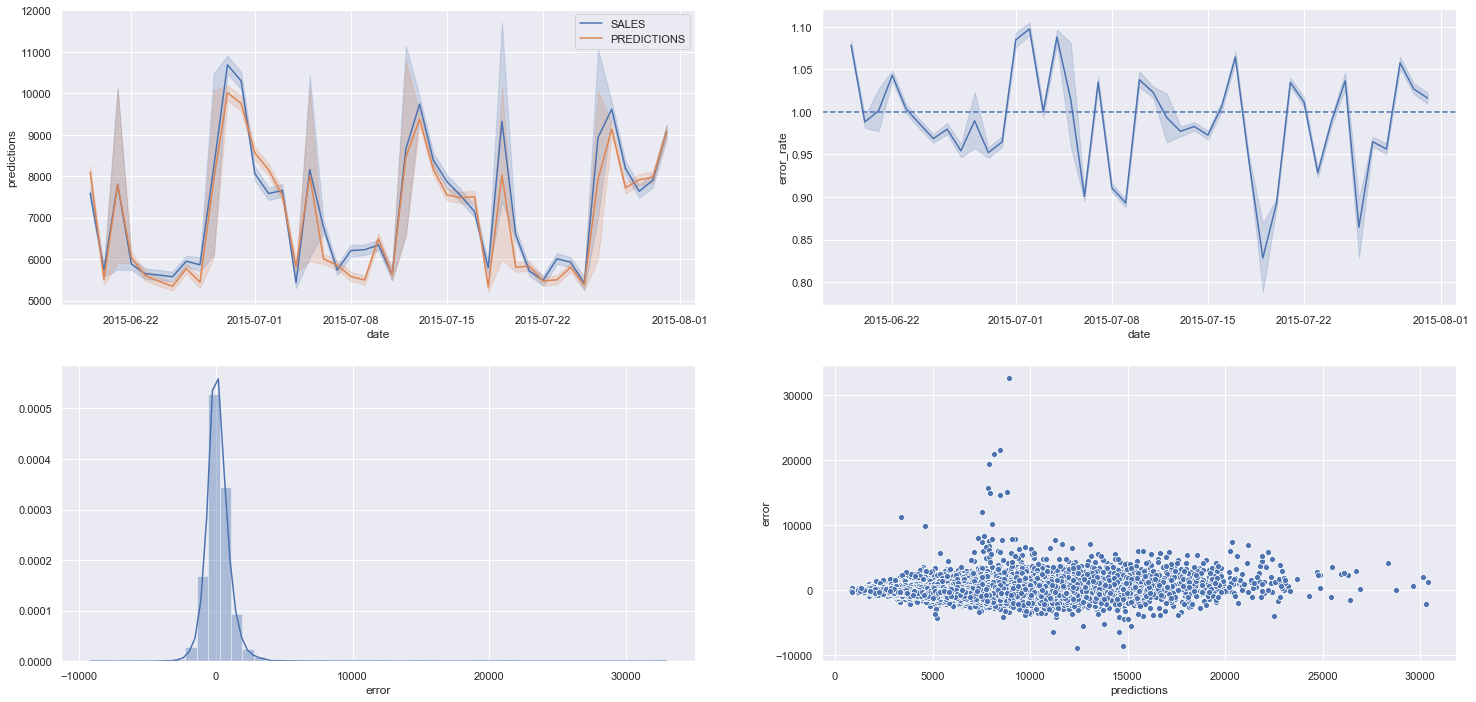

In [194]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);

In [88]:
import pickle

In [95]:
pickle.dump( model_xgb_tuned, open('/Users/andre.vitorino/Documents/repos/Predict-Time-Series-Test/model/model_rossmann.pkl', 'wb'))